In [1]:
from common import colors, sbarlw

In [2]:
import os
os.chdir(os.path.join('..', '..'))
print(os.getcwd())

/Users/eharkin/Documents/projects/5HTGIF


In [3]:
from __future__ import division

import pickle
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
import pandas as pd

from ezephys.rectools import ABFLoader
from grr.cell_class import (
    subtract_baseline,
    subtract_leak,
)
from grr import pltools
from grr.CurveFit import fit_decay_curve, fit_gating_curve, plot_linear_fit
from grr.Tools import dashedBorder, timeToIndex, getIndicesByPercentile, stripNan

In [4]:
IMG_PATH = os.path.join('figs', 'ims', 'writeup', 'fig1')
NOTEBOOK_PATH = os.path.join('figs', 'scripts')

plt.style.use(os.path.join(NOTEBOOK_PATH, 'publication_figure_style.dms'))

In [5]:
# Load V-steps files

loader = ABFLoader()

DATA_PATH = os.path.join('data', 'raw', 'mPFC', 'gating')

fnames = pd.read_csv(os.path.join(DATA_PATH, 'index.csv'))

# Load gating data
gating = loader.load([os.path.join(DATA_PATH, fname) for fname in fnames['steps']])


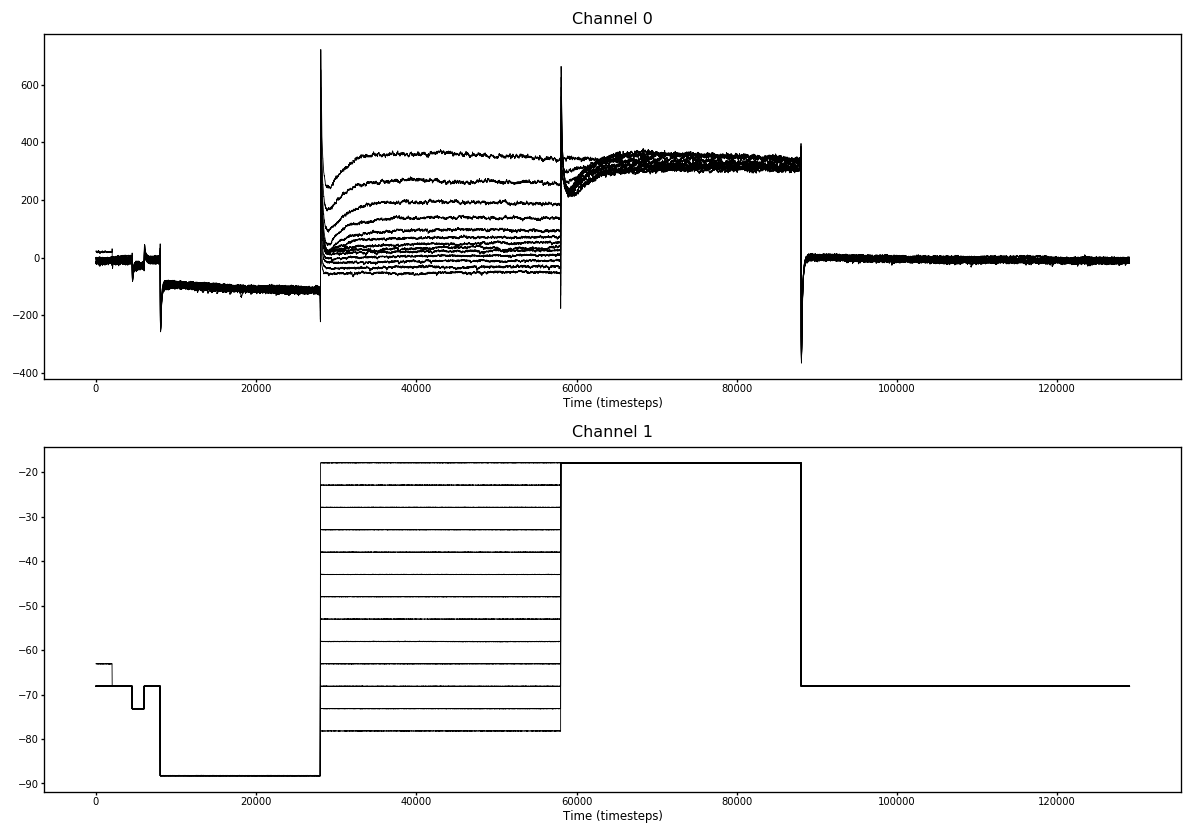

In [6]:
gating[0].plot()

In [7]:
print(gating[0][1, 0, :])
print(gating[0][1, 20000, :])
print(gating[0][1, 40000, :])

[-63.07983398 -68.11523438 -68.11523438 -68.0847168  -68.17626953
 -68.14575195 -68.14575195 -68.17626953 -68.17626953 -68.14575195
 -68.14575195 -68.14575195 -68.14575195]
[-88.22631836 -88.22631836 -88.22631836 -88.25683594 -88.22631836
 -88.28735352 -88.25683594 -88.22631836 -88.28735352 -88.28735352
 -88.22631836 -88.22631836 -88.19580078]
[-78.18603516 -73.21166992 -68.14575195 -63.07983398 -58.07495117
 -53.0090332  -48.03466797 -43.02978516 -38.02490234 -32.98950195
 -27.98461914 -22.88818359 -17.91381836]


# Subtract baseline/leak

(0, 60000)

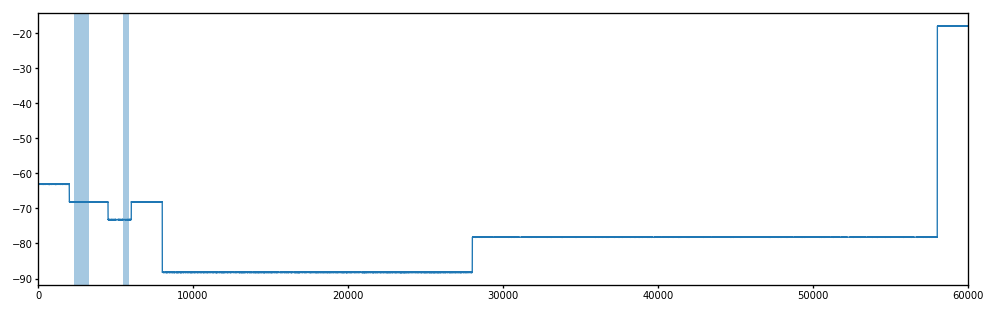

In [8]:
plt.figure(figsize=(10, 3))

plt.plot(gating[0][1, :, 0])
plt.axvspan(2300, 3300, alpha=0.4)
plt.axvspan(5500, 5900, alpha=0.4)
plt.xlim(0, 60000)

In [9]:
gating_tmp = []
for rec in gating:
    baseline_subtracted = subtract_baseline(rec, slice(2300, 3300), 0)
    leak_subtracted = subtract_leak(baseline_subtracted, slice(2300, 3300), slice(5500, 5900))
    gating_tmp.append(leak_subtracted)
gating = gating_tmp
del gating_tmp, baseline_subtracted, leak_subtracted 

# Fit decay

(28010, 35000)

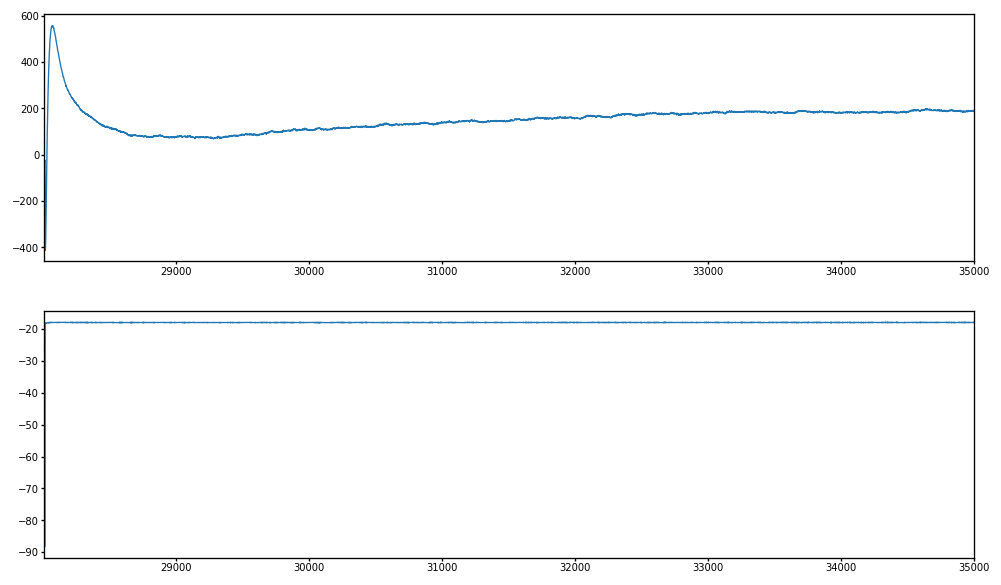

In [10]:
xlims = (28010, 35000)

plt.figure(figsize=(10, 6))

plt.subplot(211)
plt.plot(gating[0][0, :, -1])
plt.xlim(xlims)

plt.subplot(212)
plt.plot(gating[0][1, :, -1])
plt.axvspan(2300, 3300, alpha=0.4)
plt.axvspan(5500, 5900, alpha=0.4)
plt.xlim(xlims)

In [11]:
step_amplitude = 50  # 70mV (-70 to -20)

IA_inactivation = {
    'traces': [],
    'fitted_data': [],
    'fitted_curves': [], 
    'range_fitted': [],
    'inactivation_taus': [],
    'peak_latencies': [],
    'peak_amplitudes': [],
    'steady_state_amplitudes': [],
    'peak_exists': []
}

peak_fit_params = {
    'stimulus_start_time': 2801.6,
    'steady_state_time': 3801.6,
    'peak_slice': slice(28036, 28500),
    'decay_slice_end': 29000
}

for i in range(len(gating)):
    
    peak_inds = find_peaks(
        gating[i][0, peak_fit_params['peak_slice'], -1],
        distance=500,
        prominence=50.,
        width=100
    )[0]
    if len(peak_inds) > 0:
        if len(peak_inds) > 1:
            warnings.warn(
                '{} peaks detected for recording {}.'.format(len(peak_inds), i)
            )
        peak_exists = True
        peak_ind = np.argmax(gating[i][0, peak_fit_params['peak_slice'], -1])
    else:
        peak_exists = False
    IA_inactivation['peak_exists'].append(peak_exists)
    
    # Find peak latency
    if peak_exists:
        IA_inactivation['peak_latencies'].append(
            peak_ind * 0.1 
            + peak_fit_params['peak_slice'].start * 0.1 
            - peak_fit_params['stimulus_start_time']
        )
    else:
        IA_inactivation['peak_latencies'].append(np.nan)
    
    # Get steady-state amplitude
    steady_state_amplitude = gating[i][0, timeToIndex(peak_fit_params['steady_state_time'], 0.1)[0], -1]
    IA_inactivation['steady_state_amplitudes'].append(steady_state_amplitude)
    
    # Get peak amplitude.
    if peak_exists:
        peak_amplitude = gating[i][0, peak_ind + peak_fit_params['peak_slice'].start, -1]
        IA_inactivation['peak_amplitudes'].append(peak_amplitude)
    else:
        IA_inactivation['peak_amplitudes'].append(np.nan)
    
    # Fit decay
    if peak_exists:
        
        # Convert decay_slice to eighty twenty range
        decay_slice = slice(peak_ind + peak_fit_params['peak_slice'].start, peak_fit_params['decay_slice_end'])
        decay_slice = getIndicesByPercentile(gating[i][0, decay_slice, -1], [0.80, 0.20]) + decay_slice.start  # Get 80-20 interval
        decay_slice[1] = np.argmin(gating[i][0, decay_slice[0]:decay_slice[1], -1]) + decay_slice[0]  # Truncate to min.

        decay_slice += peak_ind
        decay_slice = slice(decay_slice[0], decay_slice[1])
        plt.plot(gating[i][0, decay_slice, -1])
        plt.show()
        IA_inactivation['range_fitted'].append([decay_slice.start * 0.1, decay_slice.stop * 0.1])
        

        t_vec = np.arange(0, gating[i].shape[1], 0.1)[:gating[i].shape[1]]
        fitted_tmp = gating[i][0, decay_slice, -1]
        IA_inactivation['fitted_data'].append(np.array(
            [fitted_tmp,
            t_vec[decay_slice]]
        ))

        IA_inactivation['traces'].append(np.array([gating[i][0, :, -1], gating[i][1, :, -1], t_vec]))

        p_tmp, fitted_tmp = fit_decay_curve(
            fitted_tmp,
            [fitted_tmp[0] - fitted_tmp[-1], fitted_tmp[-1], 20],
            dt = 0.1
        )

        IA_inactivation['inactivation_taus'].append(p_tmp[2])
        IA_inactivation['fitted_curves'].append(np.array(
            [fitted_tmp[0, :],
            np.linspace(decay_slice.start * 0.1, decay_slice.stop * 0.1, len(fitted_tmp[0, :]))]
        ))

        # Diagnostic plot of decay fit.
        plt.figure()
        plt.axhline(peak_amplitude)
        plt.axvline((peak_ind + peak_fit_params['peak_slice'].start) * 0.1)
        plt.plot(t_vec, gating[i][0, :, -1], 'k-', lw=0.5)
        #plt.plot(t_vec[peak_fit_params['decay_slice']], gating[i][0, peak_fit_params['decay_slice'], -1], 'r-')
        plt.plot(
            np.linspace(
                decay_slice.start * 0.1, decay_slice.stop * 0.1, len(fitted_tmp[0, :])
            ),
            fitted_tmp[0, :], '--', color = 'gray', lw=4
        )
        plt.xlim(2600, 4000)
        plt.show()
    else:
        IA_inactivation['range_fitted'].append([np.nan, np.nan])
        IA_inactivation['traces'].append(np.array([gating[i][0, :, -1], gating[i][1, :, -1], gating[i].time_supp]))
        IA_inactivation['inactivation_taus'].append(np.nan)
        IA_inactivation['fitted_curves'].append(None)
                                         


for key in IA_inactivation:
    if key != 'fitted_data':
        IA_inactivation[key] = np.array(IA_inactivation[key])
print('IA inactivation tau {:.1f} +/- {:.1f} (mean +/- SD)'.format(
    IA_inactivation['inactivation_taus'].mean(), IA_inactivation['inactivation_taus'].std()
))

#with open(PROCESSED_PATH + 'inactivation_fits.dat', 'wb') as f:
#    pickle.dump(IA_inactivation, f)

IA inactivation tau nan +/- nan (mean +/- SD)


In [12]:
print(np.sum(IA_inactivation['peak_exists']) / len(IA_inactivation['peak_exists']))

0.0


In [13]:
IA_inactivation.keys()

['peak_latencies',
 'steady_state_amplitudes',
 'inactivation_taus',
 'peak_amplitudes',
 'peak_exists',
 'fitted_data',
 'fitted_curves',
 'traces',
 'range_fitted']

In [14]:
for dataset in ['peak_amplitudes', 'peak_latencies', 'steady_state_amplitudes', 'inactivation_taus']:
    print('{:>25} {:>10.3} +/- {:>5.3}'.format(
        dataset, 
        np.nanmean(IA_inactivation[dataset]), 
        stats.sem(IA_inactivation[dataset], nan_policy='omit')
    ))

          peak_amplitudes        nan +/-   0.0
           peak_latencies        nan +/-   0.0
  steady_state_amplitudes    3.8e+02 +/-  80.4
        inactivation_taus        nan +/-   0.0


/miniconda3/envs/neopozz/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


## Summary statistics for quantities in nS

In [15]:
print('Peak amplitudes (nS) {:>20.3} +/- {:>5.3}'.format(
    np.nanmean(IA_inactivation['peak_amplitudes'] / step_amplitude),
    stats.sem(IA_inactivation['peak_amplitudes'] / step_amplitude, nan_policy='omit')
))
print('Steady state amplitudes (nS) {:>20.3} +/- {:>5.3}'.format(
    np.nanmean(IA_inactivation['steady_state_amplitudes'] / step_amplitude),
    stats.sem(IA_inactivation['steady_state_amplitudes'] / step_amplitude, nan_policy='omit')
))

Peak amplitudes (nS)                  nan +/-   0.0
Steady state amplitudes (nS)                  7.6 +/-  1.61


/miniconda3/envs/neopozz/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [16]:
IA_inactivation['steady_state_conductance'] = IA_inactivation['steady_state_amplitudes'] / step_amplitude
IA_inactivation['peak_conductance'] = IA_inactivation['peak_amplitudes'] / step_amplitude

In [17]:
statistics = [
    'peak_latencies', 
    'steady_state_amplitudes', 
    'steady_state_conductance', 
    'peak_conductance', 
    'inactivation_taus',
    'peak_exists'
]
stats_df = pd.DataFrame({key: IA_inactivation[key] for key in statistics})

In [18]:
stats_df

,inactivation_taus,peak_conductance,peak_exists,peak_latencies,steady_state_amplitudes,steady_state_conductance
0,NaN,NaN,False,NaN,195.007800,3.900156
1,NaN,NaN,False,NaN,561.597282,11.231946
2,NaN,NaN,False,NaN,107.400664,2.148013
3,NaN,NaN,False,NaN,406.864589,8.137292
4,NaN,NaN,False,NaN,402.632536,8.052651
5,NaN,NaN,False,NaN,605.952969,12.119059


In [19]:
stats_df.mean()

inactivation_taus                  NaN
peak_conductance                   NaN
peak_exists                   0.000000
peak_latencies                     NaN
steady_state_amplitudes     379.909307
steady_state_conductance      7.598186
dtype: float64

In [20]:
stats_df.sem()

inactivation_taus                 NaN
peak_conductance                  NaN
peak_exists                  0.000000
peak_latencies                    NaN
steady_state_amplitudes     80.373859
steady_state_conductance     1.607477
dtype: float64

In [21]:
stats_df.to_csv(os.path.join('data', 'processed', 'mPFC', 'transient_current_parameters.csv'), index=False)

# Figures

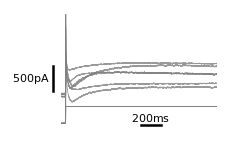

In [24]:
fit_example_no = 8
bg_tr_alpha = 0.8

tr_spec = gs.GridSpec(2, 1, height_ratios=[1, 0.2], hspace=0, top=0.97, bottom=0.05, right=0.97, left=0.1)

plt.figure(figsize=(1.5, 1))

wc_ax = plt.subplot(tr_spec[0, :])
plt.plot(
    (IA_inactivation['traces'][~IA_inactivation['peak_exists'], 2, :].T - peak_fit_params['stimulus_start_time']), 
    IA_inactivation['traces'][~IA_inactivation['peak_exists'], 0, :].T,
    '-', color='gray', lw=0.5, alpha=bg_tr_alpha
)
plt.plot(
    (IA_inactivation['traces'][IA_inactivation['peak_exists'], 2, :].T - peak_fit_params['stimulus_start_time']), 
    IA_inactivation['traces'][IA_inactivation['peak_exists'], 0, :].T,
    '-', color=colors['pyr'], lw=0.5, alpha=bg_tr_alpha
)
plt.xlim(-50, 1550)
plt.ylim(-250, 1600)
pltools.add_scalebar(y_units='pA', y_size=500, omit_x=True, anchor=(-0.05, 0.1), linewidth=sbarlw)
sns.despine(ax=plt.gca(), trim=True)

"""wc_ins = inset_axes(wc_ax, '60%', '50%', loc='upper right', borderpad=1)
plt.plot(
    (IA_inactivation['traces'][~IA_inactivation['peak_exists'], 2, :].T - peak_fit_params['stimulus_start_time']), 
    IA_inactivation['traces'][~IA_inactivation['peak_exists'], 0, :].T,
    '-', color='gray', lw=0.5, alpha=bg_tr_alpha
)
plt.plot(
    (IA_inactivation['traces'][IA_inactivation['peak_exists'], 2, :].T - peak_fit_params['stimulus_start_time']), 
    IA_inactivation['traces'][IA_inactivation['peak_exists'], 0, :].T,
    '-', color=colors['pyr'], lw=0.5, alpha=bg_tr_alpha
)
plt.xlim(-20, 150)
plt.ylim(-50, 1500)
pltools.add_scalebar(x_units='ms', x_size=50, omit_y=True, anchor=(0.95, 0.7), x_label_space=0.05, remove_frame=False, linewidth=2)
plt.xticks([])
plt.yticks([])
dashedBorder(wc_ins, lw=1.5)
mark_inset(wc_ax, wc_ins, 1, 4, ls='--', color='gray', lw=1.5)"""

plt.subplot(tr_spec[1, :])
plt.plot(
    (IA_inactivation['traces'][:, 2, :].T - peak_fit_params['stimulus_start_time']), 
    IA_inactivation['traces'][:, 1, :].T,
    '-', color=colors['input'], lw=0.5, alpha=bg_tr_alpha
)
plt.xlim(-50, 1550)
pltools.add_scalebar(x_units='ms', x_size=200, omit_y=True, anchor=(0.7, -0.05), x_label_space=0.05, linewidth=sbarlw)

plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'mPFC_kinetics_trace_only.png'))
    plt.savefig(os.path.join(IMG_PATH, 'mPFC_kinetics_trace_only.svg'))
    
plt.show()